<a href="https://colab.research.google.com/github/Anson422/Anson-Eva-Valerie/blob/main/Text%20Analysis/Code_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Anson422/Anson-Eva-Valerie.git #clone the repository to the local machine

Cloning into 'Anson-Eva-Valerie'...
remote: Enumerating objects: 5389, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 5389 (delta 150), reused 58 (delta 58), pack-reused 5205 (from 2)
Receiving objects: 100% (5389/5389), 9.01 GiB | 41.77 MiB/s, done.
Resolving deltas: 100% (1828/1828), done.
Updating files: 100% (2887/2887), done.


In [2]:
!apt-get update
!apt-get install -y poppler-utils tesseract-ocr
!pip install PyPDF2 pycryptodome pymupdf pdfplumber pdf2image pytesseract --upgrade


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,633 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,517 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-update

In [3]:
#install the necessary libraries
import os
import PyPDF2
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
import fitz  # PyMuPDF
import warnings
from collections import defaultdict
import pytesseract
import warnings
import pdfplumber
from pdf2image import convert_from_path
import sys
import logging


In [4]:
#Checking if the cloning was successfull
# Navigate to the cloned repository folder
repository_path = '/content/Anson-Eva-Valerie'

if os.path.exists(repository_path):
    print("Repository cloned successfully!")
    print("Files in the repository:", os.listdir(repository_path))
else:
    print("Repository cloning failed.")

Repository cloned successfully!
Files in the repository: ['Text Analysis', 'hello.ipynb', '.git', 'Stacked Bar Chart', 'Choropleth Map Analysis', 'README.md']


In [14]:
# Suppress all warnings globally (if needed)
warnings.simplefilter("ignore")

In [25]:
# Function to extract text using PyPDF2
def extract_text_with_pypdf2(pdf_path):
    text = ""
    try:
        reader = PdfReader(pdf_path)
        for page in reader.pages:
            text += page.extract_text() or ""
    except Exception as e:
        print(f"PyPDF2 failed for {pdf_path}: {e}")
    return text

# Function to extract text using pdfplumber
def extract_text_with_pdfplumber(pdf_path):
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() or ""
    except Exception as e:
        print(f"pdfplumber failed for {pdf_path}: {e}")
    return text

# Function to extract text using OCR
def extract_text_with_ocr(pdf_path):
    text = ""
    try:
        images = convert_from_path(pdf_path)
        for image in images:
            text += pytesseract.image_to_string(image)
    except Exception as e:
        print(f"OCR failed for {pdf_path}: {e}")
    return text

# Unified function to extract text
def extract_text_from_pdf(pdf_path):
    # Try PyPDF2
    text = extract_text_with_pypdf2(pdf_path)
    if not text.strip():  # Fallback to pdfplumber if PyPDF2 fails
        text = extract_text_with_pdfplumber(pdf_path)
    if not text.strip():  # Fallback to OCR if pdfplumber also fails
        text = extract_text_with_ocr(pdf_path)
    return text

In [6]:
# Define the folder containing the EU energy publications in 2024
EU_Energy_publications_2024 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2024'

In [7]:
# List of keyword categories and their synonyms
keyword_groups = {
    "LNG": ["LNG", "liquid natural gas"],
    "Renewable Energy": ["renewable", "clean energy", "alternative energy", "green energy"],
    "Pipeline Alternatives": ["pipeline alternatives"],
    "Coal": ["coal"],
    "Oil": ["oil", "crude oil", "petroleum"],
    "Natural Gas": ["natural gas", "methane", "shale gas", "pipeline gas"],
    "Nuclear": ["nuclear", "uranium", "fission", "fusion"],
    "Hydro": ["hydro", "water power", "hydropower", "dam energy"],
    "Biofuels": ["biofuels", "biodiesel", "bioethanol"],
    "Geothermal": ["geothermal", "ground source heat", "deep geothermal"],
    "Solar": ["solar", "photovoltaic", "PV", "solar thermal", "solar panels", "solar farms"],
    "Wind": ["wind", "offshore wind", "onshore wind", "wind turbines", "wind farms"],
    "Wave Power": ["wave power", "ocean energy", "marine energy"],
    "Biogas": ["biogas", "biomethane"],
    "Biomass": ["biomass", "wood pellets", "agricultural waste", "energy crops"],
    "Tidal": ["tidal power", "tidal energy"],
    "Fossil Fuels": ["fossil fuels", "oil", "coal", "natural gas"],
}

# Initialize category counts
category_counts = {category: 0 for category in keyword_groups}


In [16]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2024):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2024, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2024 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2024)

Processing: resilience%20assessment-KJ0124002ENN.pdf
Processing: behavioural%20insights%20applied%20to%20policy-KJ0124189ENN.pdf
Processing: addressing%20the%20regional%20dimension%20of%20open%20strategic-KJNA31868ENN.pdf
Processing: strukturlotsen%20improving%20inter-municipal%20cooperation-MJ0524516ENN.pdf
Processing: europeans%20opinions%20about%20the%20european%20unions%20priorities-NAAO24004ENN.pdf
Processing: europeans%20attitudes%20towards%20eu%20energy%20policy-MJ0924678ENN.pdf
Processing: bulgaria%20and%20its%20collaboration%20with%20the%20joint%20research-KJ0624149ENN.pdf
Processing: fisa%202022-KI0323060ENN-compressed.pdf
Processing: clean%20energy%20technology%20observatory%20hydropower%20and-KJ0124070ENN.pdf
Processing: clean%20energy%20technology%20observatory%20early%20stage%20technologies-KJNA31807ENN.pdf
Processing: ramp-up%20and%20role%20of%20hydrogen-based%20power%20generation-MJ0524460ENN.pdf
Processing: smart%20cities%20marketplace%20newsletter%2030%20may%202024-MJ

In [9]:
# Sort the DataFrame by frequency in descending order
df_2024 = df_2024.sort_values(by="Frequency", ascending=False)


In [10]:
# Define a styled DataFrame with custom styles
styled_df_2024 = df_2024.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2024)

,Category,Frequency
7,Hydro,21974
1,Renewable Energy,16957
16,Fossil Fuels,13333
6,Nuclear,12371
10,Solar,11678
11,Wind,10570
4,Oil,6672
5,Natural Gas,5064
14,Biomass,4503
3,Coal,4001


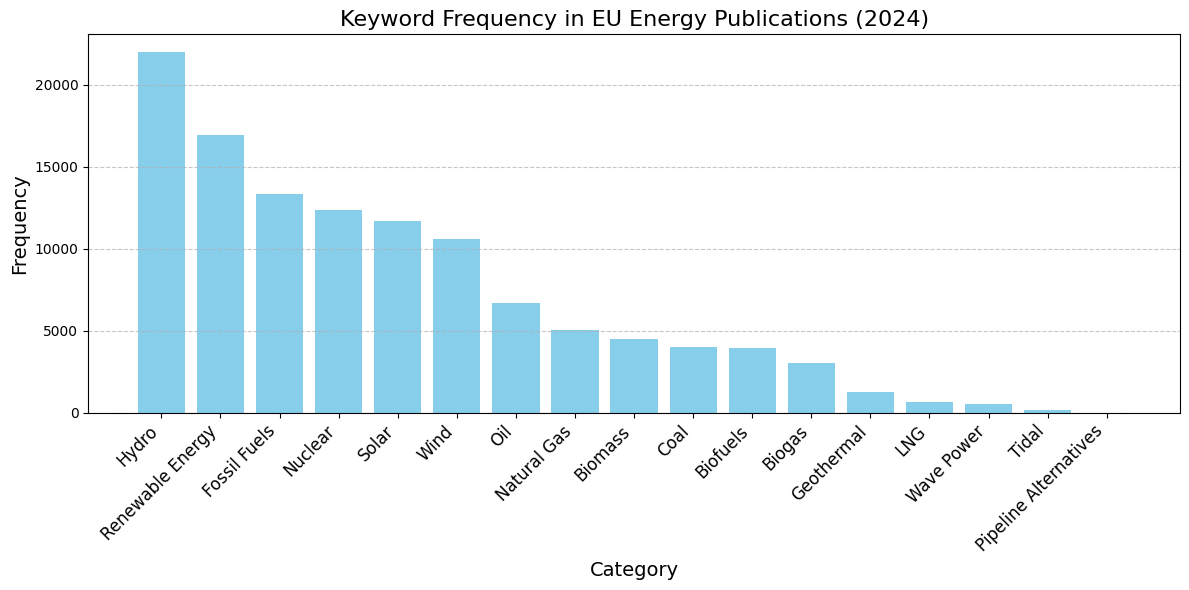

In [11]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2024["Category"], df_2024["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2024)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [12]:
# Define the folder containing the EU energy publications in 2019
EU_Energy_publications_2019 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2019'

In [26]:
# Reset counts before processing 2019 PDFs
category_counts = {category: 0 for category in keyword_groups}

# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2019):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2019, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2019 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2019)

Processing: a%20bright%20future-QH0319395ENN.pdf
Processing: operating%20experience%20with%20digital%20i%26c%20systems%20at%20nuclear-KJNA29618ENN.pdf
Processing: study%20on%20consumer%20understanding%20of%20draft%20energy%20labels-KH0419169ENN.pdf
Processing: mapping%20threats%20to%20peace%20and%20democracy%20worldwide-QA0419443ENN.pdf
Processing: dg%20energy%20news%20december%202019-MJAF19012ENN.pdf
Processing: competitiveness%20of%20renewable%20heating%20and%20cooling%20industry-MJ0319525ENN.pdf
Processing: support%20to%20key%20activities%20of%20the%20european%20technology-KI0419135ENN.pdf
Processing: effect%20of%20high%20shares%20of%20renewables%20on%20power%20systems-MJ0319327ENN.pdf
Processing: position%20paper%20on%20water%20energy%20food%20and%20ecosystems-KJNA29509ENN.pdf
Processing: inea-QJAB19014ENN.pdf
Processing: dg%20energy%20news%20march%202019-MJAF19003ENN.pdf
Processing: tabletop%20exercise-KJNA29872ENN.pdf
Processing: do%20current%20regulatory%20frameworks%20in%20the%

In [27]:
# Sort the DataFrame by frequency in descending order
df_2019 = df_2019.sort_values(by="Frequency", ascending=False)

In [28]:
# Define a styled DataFrame with custom styles
styled_df_2019 = df_2019.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2019)

,Category,Frequency
16,Fossil Fuels,20545
10,Solar,15865
1,Renewable Energy,13049
4,Oil,12587
7,Hydro,12004
6,Nuclear,11380
11,Wind,10718
14,Biomass,5315
5,Natural Gas,5309
3,Coal,5080


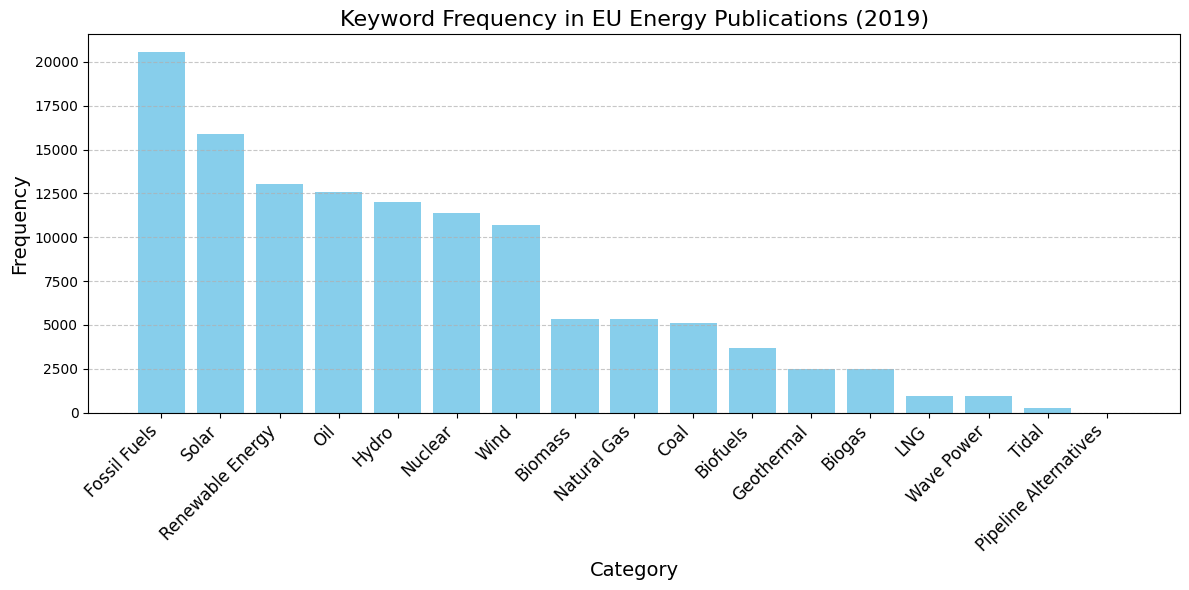

In [29]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2019["Category"], df_2019["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2019)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [21]:
# Define the folder containing the EU energy publications in 2020
EU_Energy_publications_2020 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2020'

In [33]:
# Reset counts before processing 2020 PDFs
category_counts = {category: 0 for category in keyword_groups}
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2020):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2020, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2020 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2020)

Processing: photovoltaic%20energy%20systems-KJNA30115ENN.pdf
Processing: ten%20issues%20to%20watch%20in%202020-QA0200011ENN.pdf
Processing: environmental%20statement%202020-QCAQ20001ENN.pdf
Processing: energy%20communities-KJNA30083ENN.pdf
Processing: impact%20of%20the%20use%20of%20offshore%20wind%20and%20other%20marine-QA0420605ENN.pdf
Processing: energy-efficient%20cloud%20computing%20technologies%20and-KK0320210ENN.pdf
Processing: consumer%20satisfaction%20kpis%20for%20the%20roll-out%20of%20smart-MJ0420643ENN.pdf
Processing: newsletter%20smart%20cities%20marketplace%2030%20september%202020-MJAL20003ENN.pdf
Processing: development%20of%20modular%20steel%20jacket%20for%20offshore%20windfarms-KINA30457ENN.pdf
Processing: low-maintenance%20fuel-cell%20systems%20for%20work%20and%20home-EG0220768ENN.pdf
Processing: newsletter%20smart%20cities%20marketplace%2013%20august%202020-MJAL20002ENN.pdf
Processing: reliable%20green%20power%20for%20off-grid%20communities-EG0420541ENN.pdf
Processing:

In [35]:
# Sort the DataFrame by frequency in descending order
df_2020 = df_2020.sort_values(by="Frequency", ascending=False)

In [36]:
# Define a styled DataFrame with custom styles
styled_df_2020 = df_2020.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2020)

,Category,Frequency
16,Fossil Fuels,28111
11,Wind,20496
7,Hydro,18071
10,Solar,16790
4,Oil,16102
1,Renewable Energy,15306
6,Nuclear,10881
5,Natural Gas,8745
3,Coal,7966
0,LNG,7786


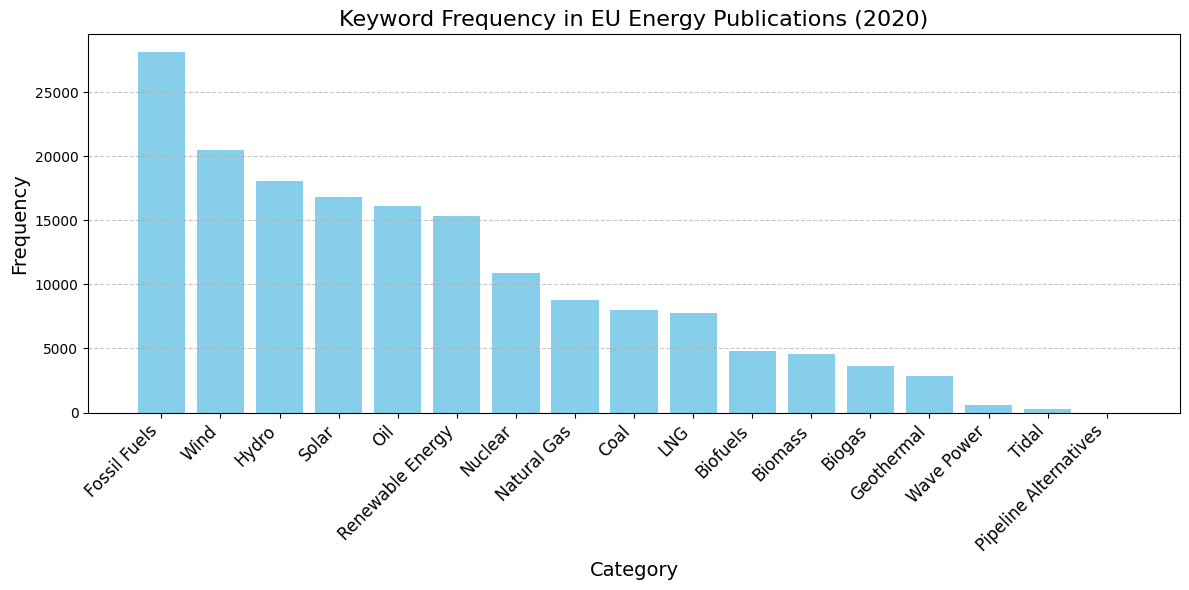

In [37]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2020["Category"], df_2020["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2020)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [38]:
# Define the folder containing the EU energy publications in 2021
EU_Energy_publications_2021 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2021'

In [39]:
# Reset counts before processing 2021 PDFs
category_counts = {category: 0 for category in keyword_groups}

# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2021):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2021, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2021 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2021)

Processing: cinea%20european%20climate%20infrastructure%20and%20environment-EF0221483ENN.pdf
Processing: solar%20photovoltaic%20modules%20inverters%20and%20systems-KJNA30474ENN.pdf
Processing: 5g%20supply%20market%20trends-KK0521236ENN.pdf
Processing: geolocation%20of%20hydrogen%20production%20in%20the%20eu-MJ0320495ENN.pdf
Processing: implementation%20of%20the%20network%20code%20on%20requirements-MJ0921258ENN.pdf
Processing: dg%20energy%20news%20january%202021-MJAF21001ENN.pdf
Processing: renewable%20hydrogen%20and%20the%20%E2%80%9Cadditionality%E2%80%9D%20requirement-QMAX21036ENN.pdf
Processing: green%20growth%20jobs%20and%20social%20impacts-KH0921053ENN.pdf
Processing: chip-scale%20atomic%20clocks-KJNA30790ENN-compressed.pdf
Processing: european%20barriers%20in%20retail%20energy%20markets-MJ0221195ENN.pdf
Processing: good%20practice%20guide%20for%20validation%20of%20a%20waste%20characterisation-KJNA30761ENN.pdf
Processing: policy%20and%20regulatory%20challenges%20for%20the%20deploym

In [40]:
# Sort the DataFrame by frequency in descending order
df_2021 = df_2021.sort_values(by="Frequency", ascending=False)

In [41]:
# Define a styled DataFrame with custom styles
styled_df_2021 = df_2021.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2021)

,Category,Frequency
16,Fossil Fuels,24874
7,Hydro,21318
1,Renewable Energy,15796
6,Nuclear,13867
4,Oil,13368
5,Natural Gas,8853
10,Solar,8424
14,Biomass,6613
3,Coal,5823
11,Wind,5508


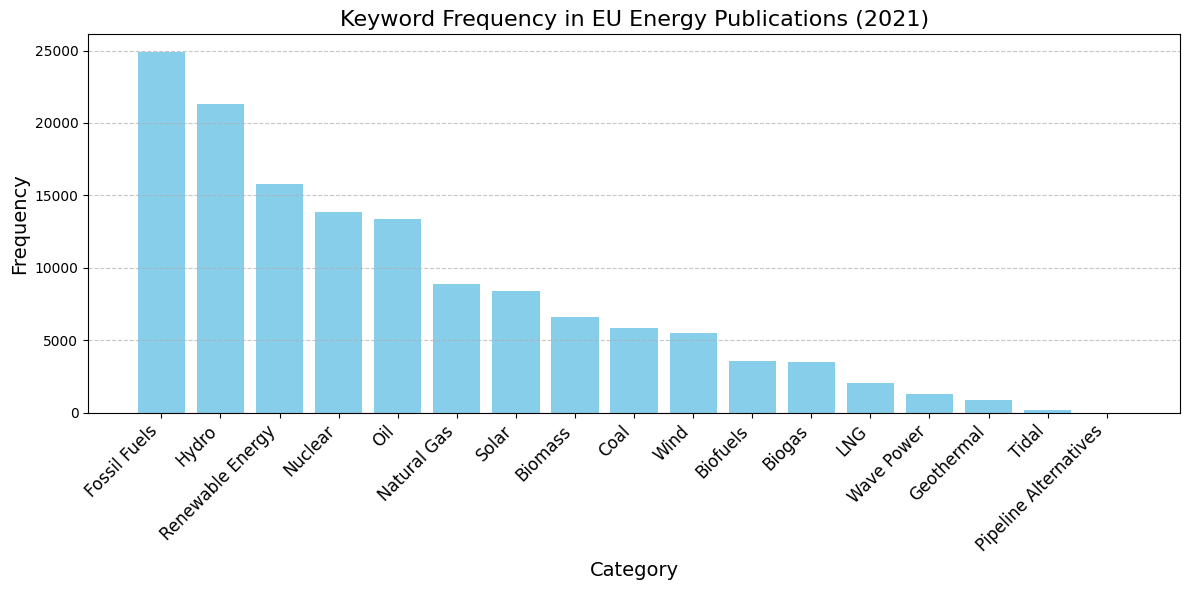

In [42]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2021["Category"], df_2021["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2021)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [43]:
# Define the folder containing the EU energy publications in 2022
EU_Energy_publications_2022 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2022'

In [47]:

# Reset counts before processing 2022 PDFs
category_counts = {category: 0 for category in keyword_groups}
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2022):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2022, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2022 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2022)

Processing: eu-africa%20global%20gateway%20investment%20package-NA0422209ENN.pdf
Processing: investors%20dialogue%20on%20energy%20newsletter%2022122022-MJAZ22004ENN.pdf
Processing: research%20and%20innovation%20to%20repower%20the%20eu-KI0122367ENN.pdf
Processing: 30%20years%20eu%20ecolabel-KH0322065ENN.pdf
Processing: further%20support%20to%20the%20preparation%20of%20an%20impact%20assessment-ML0221156ENN.pdf
Processing: dg%20energy%20news%20february%202022-MJAF22002ENN.pdf
Processing: western%20sanctions%20and%20russia-QA0822057ENN.pdf
Processing: smart%20grid%20laboratories%20inventory%202022-KJNA31062ENN.pdf
Processing: baseline%20assessment%20and%20monitoring%20of%20water%20resources-LBNA27749ENN.pdf
Processing: fly%20the%20green%20deal-KI0521325ENN.pdf
Processing: global%20energy%20and%20climate%20outlook%202022-KJNA31355ENN.pdf
Processing: protecting%20your%20ip%20in%20the%20green%20technology%20sector-EA0622080ENN.pdf
Processing: rmis%20newsletter%20special%20edition%20march%2020

In [48]:
# Sort the DataFrame by frequency in descending order
df_2022 = df_2022.sort_values(by="Frequency", ascending=False)

In [49]:
# Define a styled DataFrame with custom styles
styled_df_2022 = df_2022.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2022)

,Category,Frequency
16,Fossil Fuels,21135
7,Hydro,20814
1,Renewable Energy,18241
4,Oil,13875
10,Solar,13078
11,Wind,11358
6,Nuclear,7107
5,Natural Gas,5378
14,Biomass,4806
3,Coal,3551


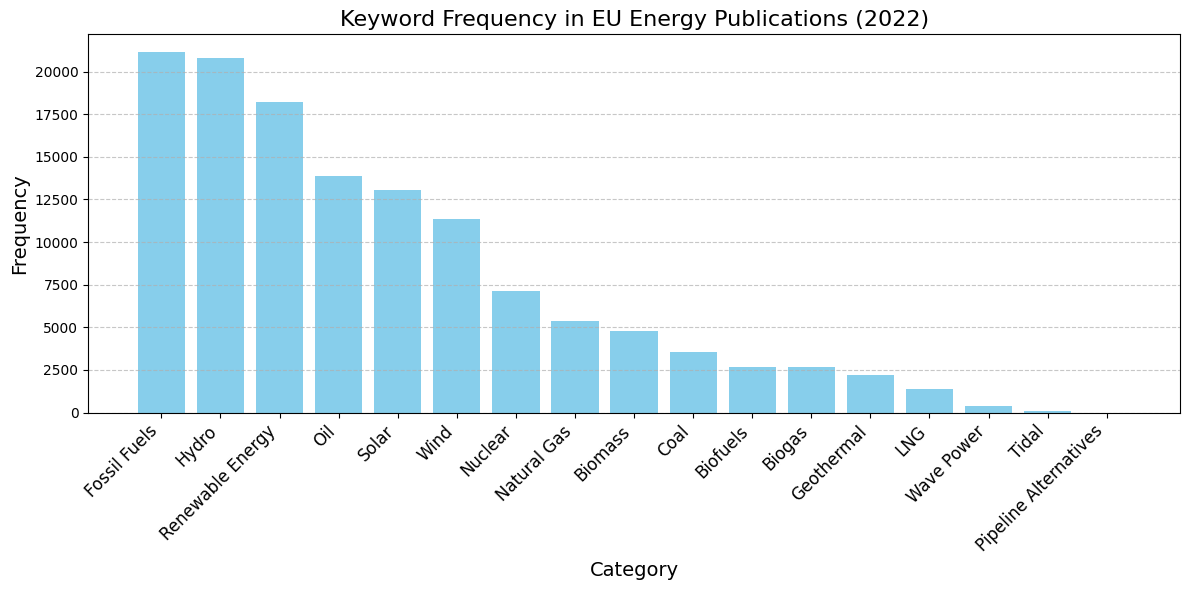

In [50]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2022["Category"], df_2022["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2022)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [51]:
# Define the folder containing the EU energy publications in 2023
EU_Energy_publications_2023 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2023'

In [52]:
# Reset counts before processing 2023 PDFs
category_counts = {category: 0 for category in keyword_groups}
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2023):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2023, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2023 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2023)

Processing: the%20eu%20regulatory%20framework%20for%20market%20risk%20and%20prudent-DZAH23002ENN.pdf
Processing: set%20plan20progress20report202023-KJNA31719ENN_compressed.pdf
Processing: green%20deal%20call%20projects%20success%20stories-KIBK23009ENN.pdf
Processing: study%20on%20the%20long-term%20linkages%20between%20climate%20objectives-ML0523558ENN.pdf
Processing: boosting%20hydrogen%20through%20a%20european%20hydrogen%20bank-NA0423312ENN.pdf
Processing: clean%20energy%20technology%20observatory%20smart%20grids%20in-KJNA31673ENN.pdf
Processing: study%20to%20develop%20eu%20level%20simplified%20cost%20options-KN0923408ENN.pdf
Processing: guide%20on%20financing%20the%20green%20energy%20transition%20of-KL0323424ENN.pdf
Processing: local%20and%20regional%20authorities%20in%20the%20governance%20of-QG0723344ENN.pdf
Processing: overview%20of%20seismic%20and%20energy%20retrofit%20technologies-KJNA31685ENN.pdf
Processing: enabling%20energy%20communities-KN0423998ENN.pdf
Processing: small%20mo

In [61]:
# Sort the DataFrame by frequency in descending order
df_2023 = df_2023.sort_values(by="Frequency", ascending=False)

In [54]:
# Define a styled DataFrame with custom styles
styled_df_2023 = df_2023.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2023)

,Category,Frequency
7,Hydro,24738
1,Renewable Energy,16806
16,Fossil Fuels,15389
10,Solar,10532
4,Oil,9994
11,Wind,9956
6,Nuclear,8343
14,Biomass,5757
5,Natural Gas,3298
3,Coal,2712


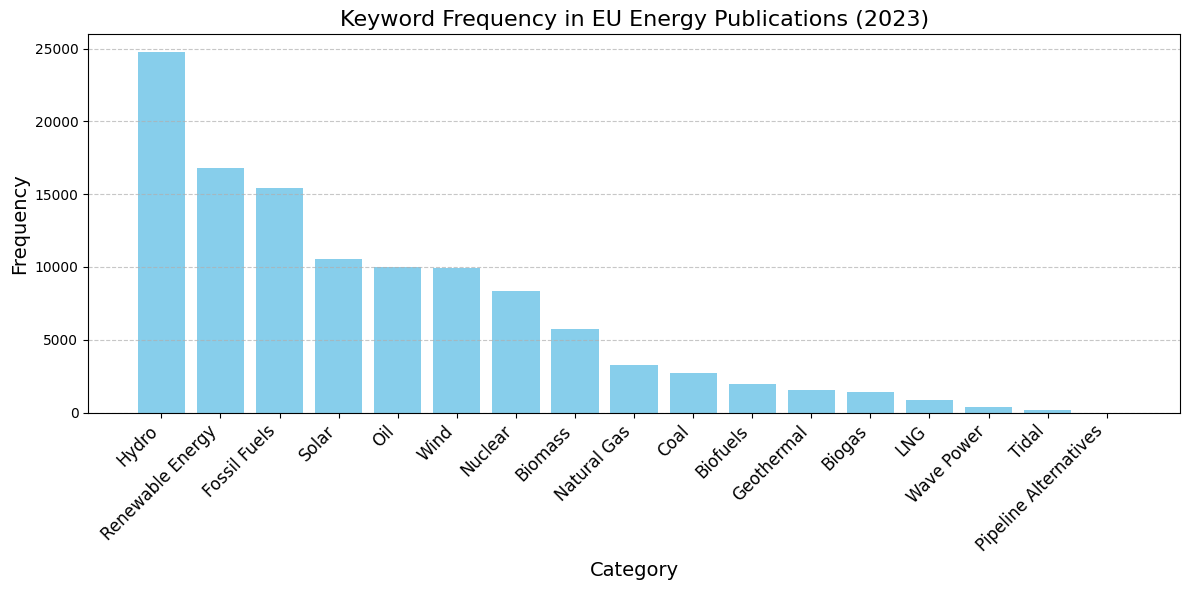

In [55]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2023["Category"], df_2023["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2023)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

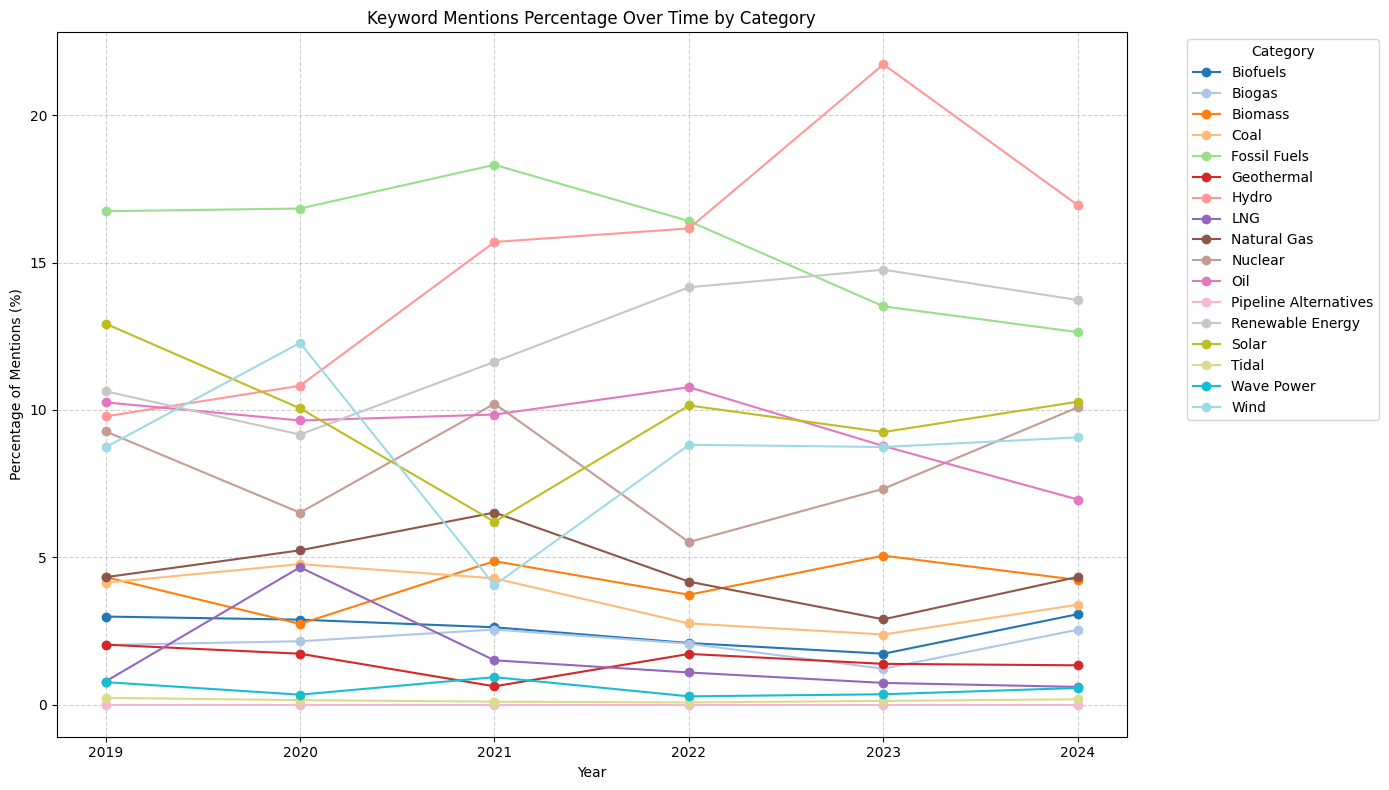

In [66]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Combine DataFrames into a single DataFrame for plotting
years = [2019, 2020, 2021, 2022, 2023, 2024]
dfs = [df_2019, df_2020, df_2021, df_2022, df_2023, df_2024]

# Ensure all DataFrames have the same categories and merge them
all_categories = sorted(set().union(*(df["Category"] for df in dfs)))  # Sort categories alphabetically
data = {"Year": []}
for category in all_categories:
    data[category] = []

for year, df in zip(years, dfs):
    data["Year"].append(year)
    total_keywords = df["Frequency"].sum()  # Total keywords for the year
    for category in all_categories:
        freq = df[df["Category"] == category]["Frequency"].sum() if category in df["Category"].values else 0
        percentage = (freq / total_keywords * 100) if total_keywords > 0 else 0  # Convert to percentage
        data[category].append(percentage)

# Create a combined DataFrame
df_combined = pd.DataFrame(data)

# Generate a colormap with one colors for each category
colormap = cm.get_cmap("tab20", len(all_categories))
colors = [colormap(i) for i in range(len(all_categories))]

# Plot the data
plt.figure(figsize=(14, 8))
for color, category in zip(colors, all_categories):
    plt.plot(df_combined["Year"], df_combined[category], marker="o", label=category, color=color)

plt.xlabel("Year")
plt.ylabel("Percentage of Mentions (%)")
plt.title("Keyword Mentions Percentage Over Time by Category")
plt.legend(
    title="Category",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    labels=sorted(all_categories),  # Sort legend labels alphabetically
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()




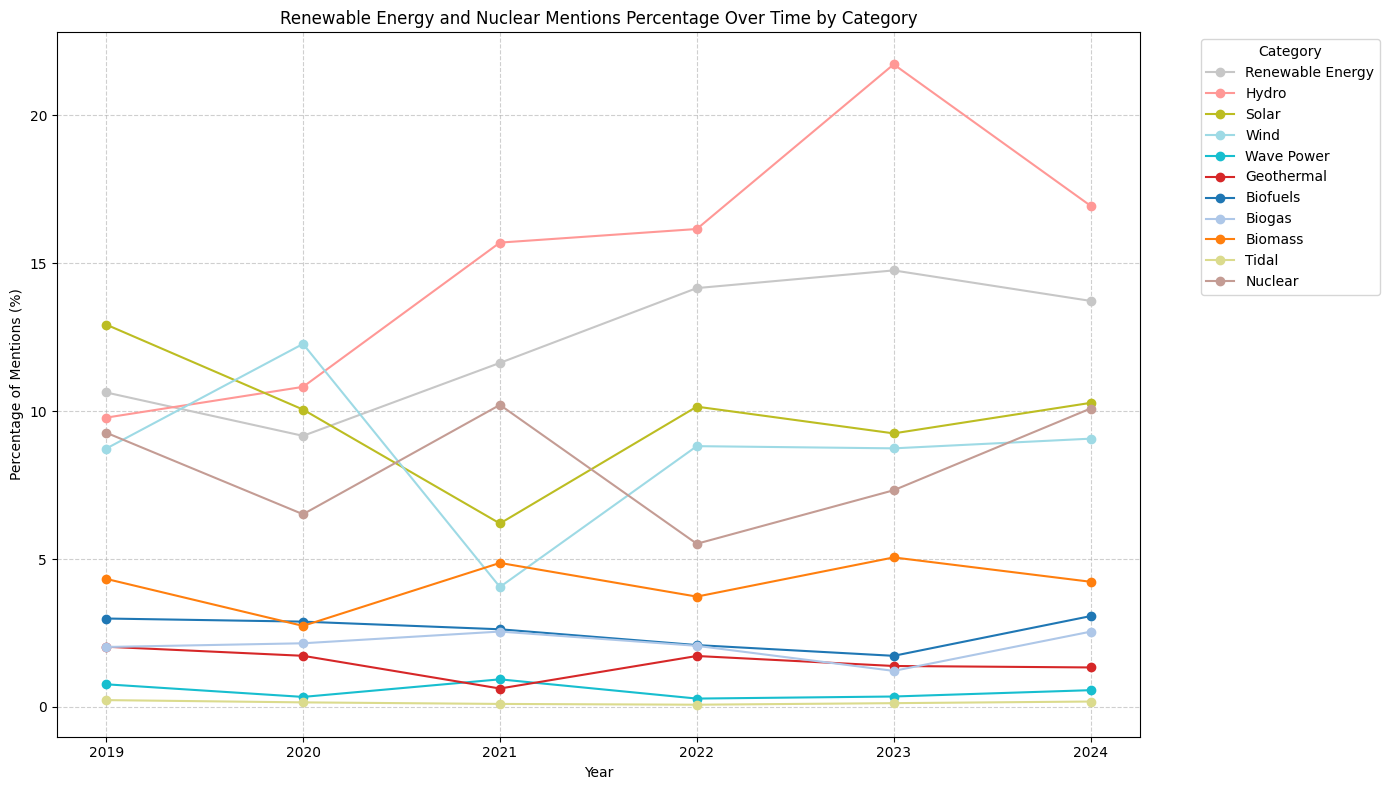

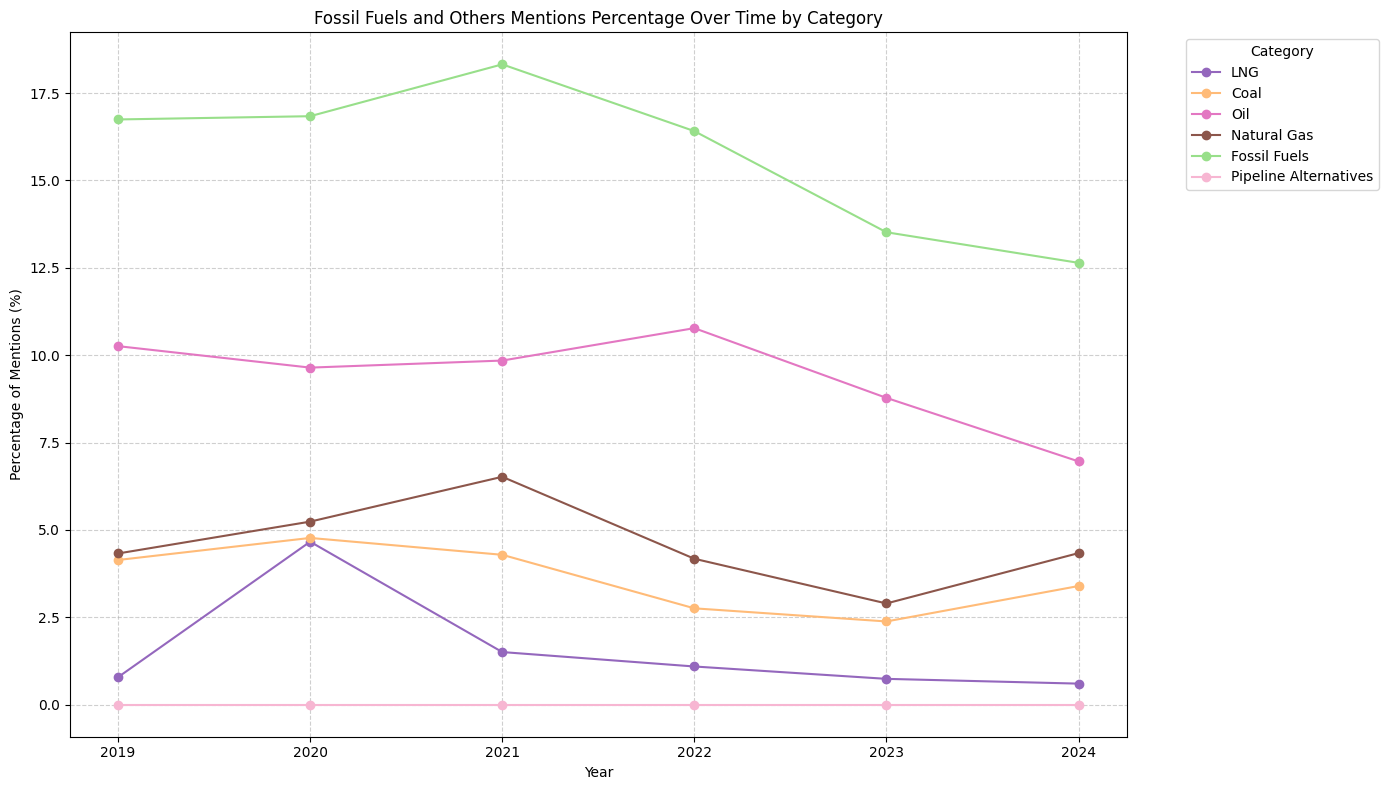

In [70]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Group categories
group1 = [
    "Renewable Energy", "Hydro", "Solar", "Wind", "Wave Power",
    "Geothermal", "Biofuels", "Biogas", "Biomass", "Tidal", "Nuclear"
]
group2 = [
    "LNG", "Coal", "Oil", "Natural Gas", "Fossil Fuels",
    "Pipeline Alternatives"
]

# Use same color map as before
colormap = cm.get_cmap("tab20", len(all_categories))
colors = [colormap(i) for i in range(len(all_categories))]

# Plotting function for each group
def plot_group(df_combined, group, group_name, colors, all_categories):
    plt.figure(figsize=(14, 8))
    plotted_categories = []  # To store the order of plotted categories for the legend
    for category in group:
        if category in df_combined.columns:
            color_index = all_categories.index(category)  # Use consistent color index
            plt.plot(df_combined["Year"], df_combined[category], marker="o", label=category, color=colors[color_index])
            plotted_categories.append(category)  # Add to plotted categories

    plt.xlabel("Year")
    plt.ylabel("Percentage of Mentions (%)")
    plt.title(f"{group_name} Mentions Percentage Over Time by Category")
    plt.legend(
        title="Category",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        labels=plotted_categories,  # Match legend to plotted categories
    )
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot Group 1 (Renewable Energy and Nuclear)
plot_group(df_combined, group1, "Renewable Energy and Nuclear", colors, all_categories)

# Plot Group 2 (Fossil Fuels and Others)
plot_group(df_combined, group2, "Fossil Fuels and Others", colors, all_categories)



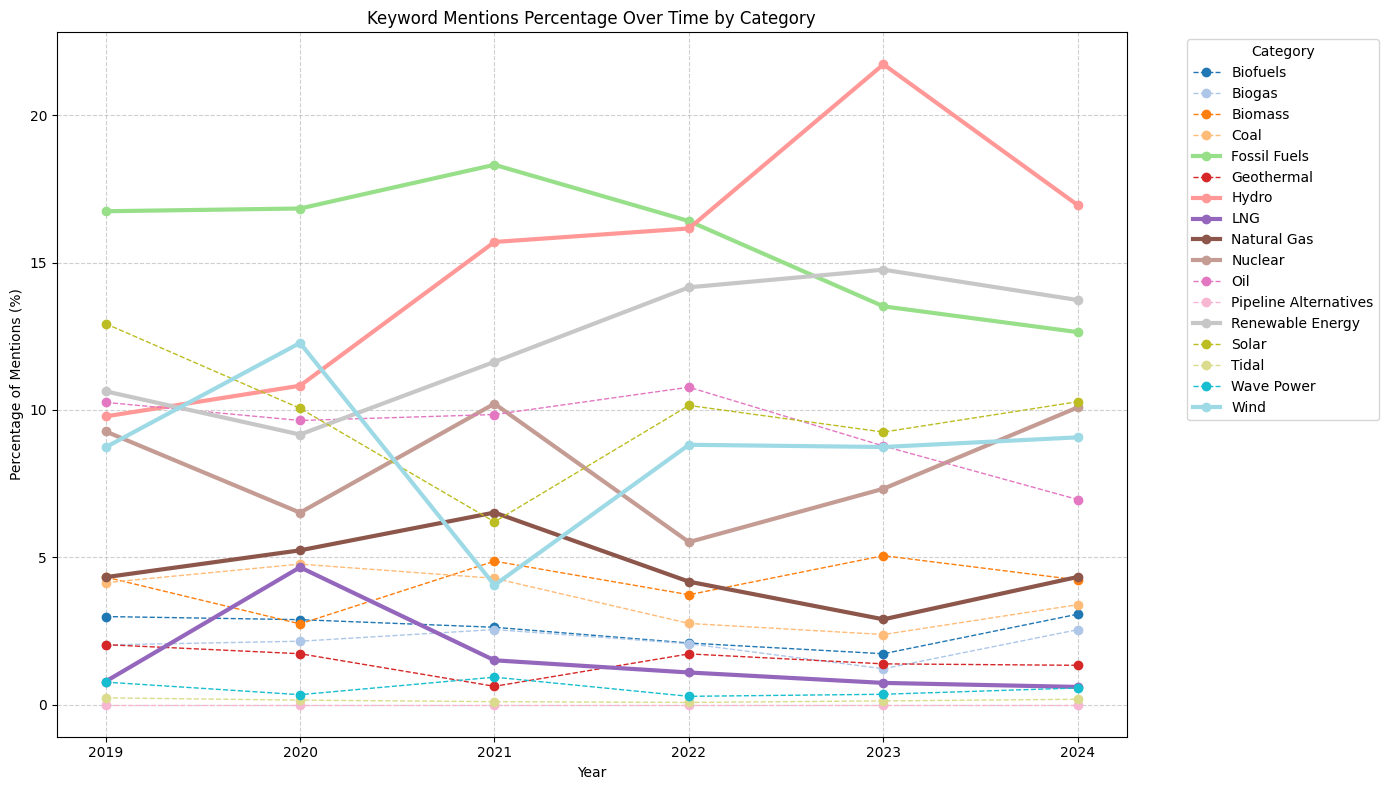

In [81]:
# Categories to highlight with thicker lines
highlight_categories = [
    "Hydro", "Natural Gas", "Nuclear", "Fossil Fuels", "LNG", "Renewable Energy", "Wind"
]

# Plot the data
plt.figure(figsize=(14, 8))

for color, category in zip(colors, all_categories):
    # If the category is in the highlight list, make the line thicker
    if category in highlight_categories:
        plt.plot(df_combined["Year"], df_combined[category], marker="o", label=category, color=color, linewidth=3)
    else:
        plt.plot(df_combined["Year"], df_combined[category], marker="o", label=category, color=color, linestyle="--", linewidth=1)

plt.xlabel("Year")
plt.ylabel("Percentage of Mentions (%)")
plt.title("Keyword Mentions Percentage Over Time by Category")
plt.legend(
    title="Category",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    labels=sorted(all_categories),  # Sort legend labels alphabetically
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [60]:
from scipy.stats import linregress

for category in df_combined.columns[1:]:
    slope, intercept, r_value, p_value, std_err = linregress(df_combined["Year"], df_combined[category])
    print(f"{category}: Slope={slope:.4f}, p-value={p_value:.4f}")

Wind: Slope=-0.1185, p-value=0.8737
Biofuels: Slope=-0.1027, p-value=0.4901
Nuclear: Slope=0.0520, p-value=0.9263
Natural Gas: Slope=-0.2662, p-value=0.4174
Tidal: Slope=-0.0099, p-value=0.5238
Biomass: Slope=0.1518, p-value=0.5127
Oil: Slope=-0.5188, p-value=0.1103
Solar: Slope=-0.3344, p-value=0.5788
Biogas: Slope=-0.0198, p-value=0.8860
Wave Power: Slope=-0.0458, p-value=0.5299
LNG: Slope=-0.3744, p-value=0.3688
Fossil Fuels: Slope=-0.9252, p-value=0.0602
Pipeline Alternatives: Slope=0.0000, p-value=1.0000
Coal: Slope=-0.3549, p-value=0.1138
Geothermal: Slope=-0.0982, p-value=0.4628
Renewable Energy: Slope=0.9939, p-value=0.0370
Hydro: Slope=1.9711, p-value=0.0344


In [77]:
import statsmodels.api as sm

# Prepare the independent variable (Year) and add a constant (intercept) for the regression
X = df_combined["Year"]
X = sm.add_constant(X)  # Add a constant (intercept) to the model

# Prepare the dependent variables (Keyword frequencies for all categories)
y = df_combined.drop(columns=["Year"])  # Drop the 'Year' column to get only the categories

# Initialize a dictionary to store the results
regression_results = {}

# Run OLS regression for each category
for category in y.columns:
    ols_model = sm.OLS(y[category], X)  # Perform OLS regression for each category
    ols_result = ols_model.fit(cov_type='HC3')  # Fit the model with robust standard errors (HC3)
    regression_results[category] = ols_result.summary()  # Store the summary for each category

# Print the regression results for each category
for category, result in regression_results.items():
    print(f"Regression results for {category}:\n")
    print(result)
    print("\n" + "="*50 + "\n")




Regression results for Biofuels:

                            OLS Regression Results                            
Dep. Variable:               Biofuels   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                 -0.093
Method:                 Least Squares   F-statistic:                    0.1690
Date:                Wed, 01 Jan 2025   Prob (F-statistic):              0.702
Time:                        18:06:29   Log-Likelihood:                -3.8846
No. Observations:                   6   AIC:                             11.77
Df Residuals:                       4   BIC:                             11.35
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        210.2

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/

In [78]:
import warnings
import statsmodels.api as sm

# Suppress the specific warning
warnings.filterwarnings("ignore", message="omni_normtest is not valid with less than 8 observations")

# Prepare the independent variable (Year) and add a constant (intercept) for the regression
X = df_combined["Year"]
X = sm.add_constant(X)  # Add a constant (intercept) to the model

# Prepare the dependent variables (Keyword frequencies for all categories)
y = df_combined.drop(columns=["Year"])  # Drop the 'Year' column to get only the categories

# Initialize a dictionary to store the results
regression_results = {}

# Run OLS regression for each category
for category in y.columns:
    ols_model = sm.OLS(y[category], X)  # Perform OLS regression for each category
    ols_result = ols_model.fit(cov_type='HC3')  # Fit the model with robust standard errors (HC3)
    regression_results[category] = ols_result.summary()  # Store the summary for each category

# Print the regression results for each category
for category, result in regression_results.items():
    print(f"Regression results for {category}:\n")
    print(result)
    print("\n" + "="*50 + "\n")


Regression results for Biofuels:

                            OLS Regression Results                            
Dep. Variable:               Biofuels   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                 -0.093
Method:                 Least Squares   F-statistic:                    0.1690
Date:                Wed, 01 Jan 2025   Prob (F-statistic):              0.702
Time:                        18:07:27   Log-Likelihood:                -3.8846
No. Observations:                   6   AIC:                             11.77
Df Residuals:                       4   BIC:                             11.35
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        210.2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
